In [1]:
#############################################################################
# zlib License
#
# (C) 2023 Cristóvão Beirão da Cruz e Silva <cbeiraod@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

#############################################################################
# Modified for ETROC2 I2C testing in jupyter notebooks, Murtaza Safdari
#############################################################################

# Imports

In [2]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from tqdm import tqdm
from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3

# Set defaults

### It is very important to correctly set the chip name, this value is stored with the data

In [3]:
chip_name = "ET2_W36_IP5_17"

In [4]:
# 'The port name the USB-ISS module is connected to. Default: COM3'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
chip_address = 0x60
ws_address = None

i2c_gui.__no_connect__ = False  # Set to fake connecting to an ETROC2 device
i2c_gui.__no_connect_type__ = "echo"  # for actually testing readback
#i2c_gui.__no_connect_type__ = "check"  # default behaviour

# Start logger and connect

In [5]:
## Logger
log_level=30
logging.basicConfig(format='%(asctime)s - %(levelname)s:%(name)s:%(message)s')
logger = logging.getLogger("Script_Logger")
Script_Helper = i2c_gui.ScriptHelper(logger)

## USB ISS connection
conn = i2c_gui.Connection_Controller(Script_Helper)
conn.connection_type = "USB-ISS"
conn.handle: USB_ISS_Helper
conn.handle.port = port
conn.handle.clk = 100

conn.connect()

chip = i2c_gui.chips.ETROC2_Chip(parent=Script_Helper, i2c_controller=conn)
chip.config_i2c_address(chip_address)
# chip.config_waveform_sampler_i2c_address(ws_address)  # Not needed if you do not access WS registers
logger.setLevel(log_level)

# Useful Functions to streamline register reading and writing

In [6]:
def pixel_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Pixel Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_indexed_var("ETROC2", "Pixel Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Pixel Config", decodedRegisterName)

def pixel_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_indexed_var("ETROC2", f"Pixel {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Pixel {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

def peripheral_decoded_register_write(decodedRegisterName, data_to_write):
    bit_depth = register_decoding["ETROC2"]["Register Blocks"]["Peripheral Config"][decodedRegisterName]["bits"]
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", decodedRegisterName)
    chip.read_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)
    if len(data_to_write)!=bit_depth: print("Binary data_to_write is of incorrect length for",decodedRegisterName, "with bit depth", bit_depth)
    data_hex_modified = hex(int(data_to_write, base=2))
    if(bit_depth>1): handle.set(data_hex_modified)
    elif(bit_depth==1): handle.set(data_to_write)
    else: print(decodedRegisterName, "!!!ERROR!!! Bit depth <1, how did we get here...")
    chip.write_decoded_value("ETROC2", "Peripheral Config", decodedRegisterName)

def peripheral_decoded_register_read(decodedRegisterName, key, need_int=False):
    handle = chip.get_decoded_display_var("ETROC2", f"Peripheral {key}", decodedRegisterName)
    chip.read_decoded_value("ETROC2", f"Peripheral {key}", decodedRegisterName)
    if(need_int): return int(handle.get(), base=16)
    else: return handle.get()

# Check if any pixels are broken

### If a pixel returns a COL and ROW number that inconsistent with the pixel that we are addressing, then it is broken

In [7]:
Failure_map = np.zeros((16,16))
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row in range(16):
    for col in range(16):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        fetched_row = pixel_decoded_register_read("PixelID-Row", "Status", need_int=True)
        fetched_col = pixel_decoded_register_read("PixelID-Col", "Status", need_int=True)
        if(row!=fetched_row or col!=fetched_col):
            print("Fail!", row, col, fetched_row, fetched_col)
            Failure_map[15-row,15-col] = 1

In [8]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt

### Pixel map, any broken pixels will show up as map == 1

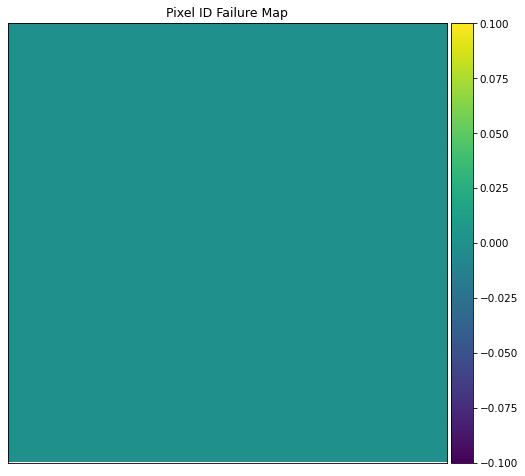

In [9]:
fig = plt.figure(dpi=75, figsize=(8,8))
gs = fig.add_gridspec(1,1)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("Pixel ID Failure Map")
img0 = ax0.imshow(Failure_map, interpolation='none')
ax0.set_aspect("equal")
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

plt.show()

### We should refrain from using broken pixels for any studies

# Check basic I2C functionatity and consistency

### Quick test using peripheral registers

In [11]:
peripheralRegisterKeys = [i for i in range(32)]
for peripheralRegisterKey in peripheralRegisterKeys:
    # Fetch the register
    handle_PeriCfgX = chip.get_display_var("ETROC2", "Peripheral Config", f"PeriCfg{peripheralRegisterKey}")
    chip.read_register("ETROC2", "Peripheral Config", f"PeriCfg{peripheralRegisterKey}")
    data_bin_PeriCfgX = format(int(handle_PeriCfgX.get(), base=16), '08b')
    # Make the flipped bits
    # data_bin_modified_PeriCfgX = list(data_bin_PeriCfgX)
    data_bin_modified_PeriCfgX = data_bin_PeriCfgX.replace('1', '2').replace('0', '1').replace('2', '0')
    # data_bin_modified_PeriCfgX = ''.join(data_bin_modified_PeriCfgX)
    data_hex_modified_PeriCfgX = hex(int(data_bin_modified_PeriCfgX, base=2))
    # Set the register with the value
    handle_PeriCfgX.set(data_hex_modified_PeriCfgX)
    chip.write_register("ETROC2", "Peripheral Config", f"PeriCfg{peripheralRegisterKey}")
    # Perform two reads to verify the persistence of the change
    chip.read_register("ETROC2", "Peripheral Config", f"PeriCfg{peripheralRegisterKey}")
    data_bin_new_1_PeriCfgX = format(int(handle_PeriCfgX.get(), base=16), '08b')
    chip.read_register("ETROC2", "Peripheral Config", f"PeriCfg{peripheralRegisterKey}")
    data_bin_new_2_PeriCfgX = format(int(handle_PeriCfgX.get(), base=16), '08b')
    # Undo the change to recover the original register value, and check for consistency
    handle_PeriCfgX.set(hex(int(data_bin_PeriCfgX, base=2)))
    chip.write_register("ETROC2", "Peripheral Config", f"PeriCfg{peripheralRegisterKey}")
    chip.read_register("ETROC2", "Peripheral Config", f"PeriCfg{peripheralRegisterKey}")
    data_bin_recover_PeriCfgX = format(int(handle_PeriCfgX.get(), base=16), '08b')
    # Handle what we learned from the tests
    print(f"PeriCfg{peripheralRegisterKey:2}", data_bin_PeriCfgX, "To", data_bin_new_1_PeriCfgX,  "To", data_bin_new_2_PeriCfgX, "To", data_bin_recover_PeriCfgX)
    if(data_bin_new_1_PeriCfgX!=data_bin_new_2_PeriCfgX or data_bin_new_2_PeriCfgX!=data_bin_modified_PeriCfgX or data_bin_recover_PeriCfgX!=data_bin_PeriCfgX): 
       print(f"PeriCfg{peripheralRegisterKey:2}", "FAILURE")


PeriCfg 0 00101100 To 11010011 To 11010011 To 00101100
PeriCfg 1 10011000 To 01100111 To 01100111 To 10011000
PeriCfg 2 00101001 To 11010110 To 11010110 To 00101001
PeriCfg 3 00011000 To 11100111 To 11100111 To 00011000
PeriCfg 4 00100001 To 11011110 To 11011110 To 00100001
PeriCfg 5 00000000 To 11111111 To 11111111 To 00000000
PeriCfg 6 00000011 To 11111100 To 11111100 To 00000011
PeriCfg 7 10100011 To 01011100 To 01011100 To 10100011
PeriCfg 8 11100011 To 00011100 To 00011100 To 11100011
PeriCfg 9 11100011 To 00011100 To 00011100 To 11100011
PeriCfg10 11010000 To 00101111 To 00101111 To 11010000
PeriCfg11 00010000 To 11101111 To 11101111 To 00010000
PeriCfg12 00000000 To 11111111 To 11111111 To 00000000
PeriCfg13 10000000 To 01111111 To 01111111 To 10000000
PeriCfg14 11110000 To 00001111 To 00001111 To 11110000
PeriCfg15 01100000 To 10011111 To 10011111 To 01100000
PeriCfg16 10010000 To 01101111 To 01101111 To 10010000
PeriCfg17 10011000 To 01100111 To 01100111 To 10011000
PeriCfg18 

### Longer Test using all pixel registers, this can take upto 15 minutes

In [ ]:
pixelRegisterKeys = [i for i in range(32)]
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
for row in range(16):
    for col in range(16):
        print("Pixel", row, col)
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        for pixelRegisterKey in pixelRegisterKeys:
            # Fetch the register
            handle_PixCfgX = chip.get_indexed_var("ETROC2", "Pixel Config", f"PixCfg{pixelRegisterKey}")
            chip.read_register("ETROC2", "Pixel Config", f"PixCfg{pixelRegisterKey}")
            data_bin_PixCfgX = format(int(handle_PixCfgX.get(), base=16), '08b')
            # Make the flipped byte
            data_bin_modified_PixCfgX = data_bin_PixCfgX.replace('1', '2').replace('0', '1').replace('2', '0')
            data_hex_modified_PixCfgX = hex(int(data_bin_modified_PixCfgX, base=2))
            # Set the register with the value
            handle_PixCfgX.set(data_hex_modified_PixCfgX)
            chip.write_register("ETROC2", "Pixel Config", f"PixCfg{pixelRegisterKey}")
            # Perform two reads to verify the persistence of the change
            chip.read_register("ETROC2", "Pixel Config", f"PixCfg{pixelRegisterKey}")
            data_bin_new_1_PixCfgX = format(int(handle_PixCfgX.get(), base=16), '08b')
            chip.read_register("ETROC2", "Pixel Config", f"PixCfg{pixelRegisterKey}")
            data_bin_new_2_PixCfgX = format(int(handle_PixCfgX.get(), base=16), '08b')
            # Undo the change to recover the original register value, and check for consistency
            handle_PixCfgX.set(hex(int(data_bin_PixCfgX, base=2)))
            chip.write_register("ETROC2", "Pixel Config", f"PixCfg{pixelRegisterKey}")
            chip.read_register("ETROC2", "Pixel Config", f"PixCfg{pixelRegisterKey}")
            data_bin_recover_PixCfgX = format(int(handle_PixCfgX.get(), base=16), '08b')
            # Handle what we learned from the tests
            if(data_bin_new_1_PixCfgX!=data_bin_new_2_PixCfgX or data_bin_new_2_PixCfgX!=data_bin_modified_PixCfgX or data_bin_recover_PixCfgX!=data_bin_PixCfgX): 
                print(row,col,f"PixCfg{pixelRegisterKey:2}","FAILURE", data_bin_PixCfgX, "To", data_bin_new_1_PixCfgX,  "To", data_bin_new_2_PixCfgX, "To", data_bin_recover_PixCfgX)

# Set the basic peripheral registers

In [10]:
peripheral_decoded_register_write("EFuse_Prog", format(0x00017f0f, '032b'))     # chip ID
peripheral_decoded_register_write("singlePort", '1')                            # Set data output to right port only
peripheral_decoded_register_write("serRateLeft", '00')                          # Set Data Rates to 320 mbps
peripheral_decoded_register_write("serRateRight", '00')                         # ^^
peripheral_decoded_register_write("onChipL1AConf", '00')                        # Switches off the onboard L1A
peripheral_decoded_register_write("PLL_ENABLEPLL", '1')                         # "Enable PLL mode, active high. Debugging use only."
peripheral_decoded_register_write("chargeInjectionDelay", format(0x0a, '05b'))  # User tunable delay of Qinj pulse

# Link Reset Testing

#### Link Reset Mode allows us to put a fixed pattern on the data ports of the chip. We can then inspect the data on a scope to verify that the pattern is clearly visible and correct. Note that in this mode, the data scrambling does not happen, letting us see the actual pattern instead of an eye disgram, which is the hallmark of randomized data.

#### In 320 mbps data rate mode, The chip quadruplicates data to match 1280 mbps

#### The FPGA can use the fixed pattern coming in to verify the data lock, and check for integrity using the quadruplicated bits.

### Reset Chip Global Readout

In [19]:
# Reset output, active low
peripheral_decoded_register_write("asyResetGlobalReadout", '0')
peripheral_decoded_register_write("asyResetGlobalReadout", '1')

### Enable LINK RESET Mode

In [20]:
peripheral_decoded_register_write("asyLinkReset", '1')              # active high


### Set Test Pattern Data Type

In [21]:
peripheral_decoded_register_write("linkResetTestPattern", '1')      # 1 = fixed pattern, 0 = PRBS

### Set Fixed Test Pattern

In [22]:
# 32 bit "User-specified pattern to be sent during link reset, LSB-first"
# Note that in 320 mbps mode only the 8 LSB bits are actually used, and quadruplicated into 32 bits 
# so here "a9" is used, which is "11001001" which beacomes "11111111000000001111000000001111"
peripheral_decoded_register_write("linkResetFixedPattern", format(0x142caba9, '032b')) 

### Disable Link Reset Mode (Important to do this before real data collection)

In [23]:
## Low for real data
peripheral_decoded_register_write("asyLinkReset", '0')

# Check your data link at this point

This is shown on the FPGA GPIO LEDs, specifically LED-0 and LED-1. LED-1 is one when data link is successful. LED-0 is a latch, and is on if any errors are found in the data frames. Resetting the link can help clear the LED-0. 

## Try on-board L1A, and see if emtpy Data Frames are correctly interpreted by the FPGA

In [61]:
# "On-chip L1A mode: - 0b0x: on-chip L1A disable\n - 0b10: periodic L1A\n - 0b11: random L1A"
peripheral_decoded_register_write("onChipL1AConf", '10')

## IMPORTANT Turn OFF on-board L1A

In [62]:
peripheral_decoded_register_write("onChipL1AConf", '00')

If LED-1 is not on, then we have a data link issue. You can try to see if you get successful data link with test pattern mode. If you still fail with real data, then you can try to change the Polarity of the readout, or explore 4 combinations of "fcClkDelayEn" and "fcDataDelayEn" registers.

Clock is used to sample data from FPGA. "fcClkDelayEn" delays the clock a little bit.

"fcDataDelayEn" delays the data from the FPGA, which is essentially comparable to "fcClkDelayEn" in what it is trying to do.

## Set Peripheral Registers - Change fc clk or data delay - In Case of failing data links

### Try out 4 combinations of these 2 registers to recover the data link (LED 1 )

In [ ]:
## "0" means disable
## "1" means enable
peripheral_decoded_register_write("fcClkDelayEn", "0")
peripheral_decoded_register_write("fcDataDelayEn", "0")

In [ ]:
peripheral_decoded_register_write("fcClkDelayEn", "0")
peripheral_decoded_register_write("fcDataDelayEn", "1")

In [ ]:
peripheral_decoded_register_write("fcClkDelayEn", "1")
peripheral_decoded_register_write("fcDataDelayEn", "0")

In [ ]:
peripheral_decoded_register_write("fcClkDelayEn", "1")
peripheral_decoded_register_write("fcDataDelayEn", "1")

# Perform Auto-calibration on all pixels, one-by-one

In [17]:
# Reset the maps
BL_map_THCal = np.zeros((16,16))
NW_map_THCal = np.zeros((16,16))

In [18]:
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
data = []
# Loop for threshold calibration
for row in tqdm(range(16), desc=" row", position=0):
    for col in tqdm(range(16), desc=" col", position=1, leave=False):
# for index,row,col in zip(tqdm(range(16)), row_list, col_list):
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # Maybe required to make this work
        # pixel_decoded_register_write("enable_TDC", "0")
        # pixel_decoded_register_write("testMode_TDC", "0")
        # Enable THCal clock and buffer, disable bypass
        pixel_decoded_register_write("CLKEn_THCal", "1")
        pixel_decoded_register_write("BufEn_THCal", "1")
        pixel_decoded_register_write("Bypass_THCal", "0")
        pixel_decoded_register_write("TH_offset", format(0x07, '06b'))
        # Reset the calibration block (active low)
        pixel_decoded_register_write("RSTn_THCal", "0")
        pixel_decoded_register_write("RSTn_THCal", "1")
        # Start and Stop the calibration, (25ns x 2**15 ~ 800 us, ACCumulator max is 2**15)
        pixel_decoded_register_write("ScanStart_THCal", "1")
        pixel_decoded_register_write("ScanStart_THCal", "0")
        # Check the calibration done correctly
        if(pixel_decoded_register_read("ScanDone", "Status")!="1"): print("!!!ERROR!!! Scan not done!!!")
        BL_map_THCal[row, col] = pixel_decoded_register_read("BL", "Status", need_int=True)
        NW_map_THCal[row, col] = pixel_decoded_register_read("NW", "Status", need_int=True)
        data += [{
            'col': col,
            'row': row,
            'baseline': BL_map_THCal[row, col],
            'noise_width': NW_map_THCal[row, col],
            'timestamp': datetime.datetime.now(),
            'chip_name': chip_name,
        }]
        # Disable clock and buffer before charge injection 
        pixel_decoded_register_write("CLKEn_THCal", "0") 
        pixel_decoded_register_write("BufEn_THCal", "0")
        # Set Charge Inj Q to 15 fC
        pixel_decoded_register_write("QSel", format(0x0e, '05b'))

BL_df = pandas.DataFrame(data = data)

 row: 100%|██████████| 16/16 [01:50<00:00,  6.88s/it]


### Visulaize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

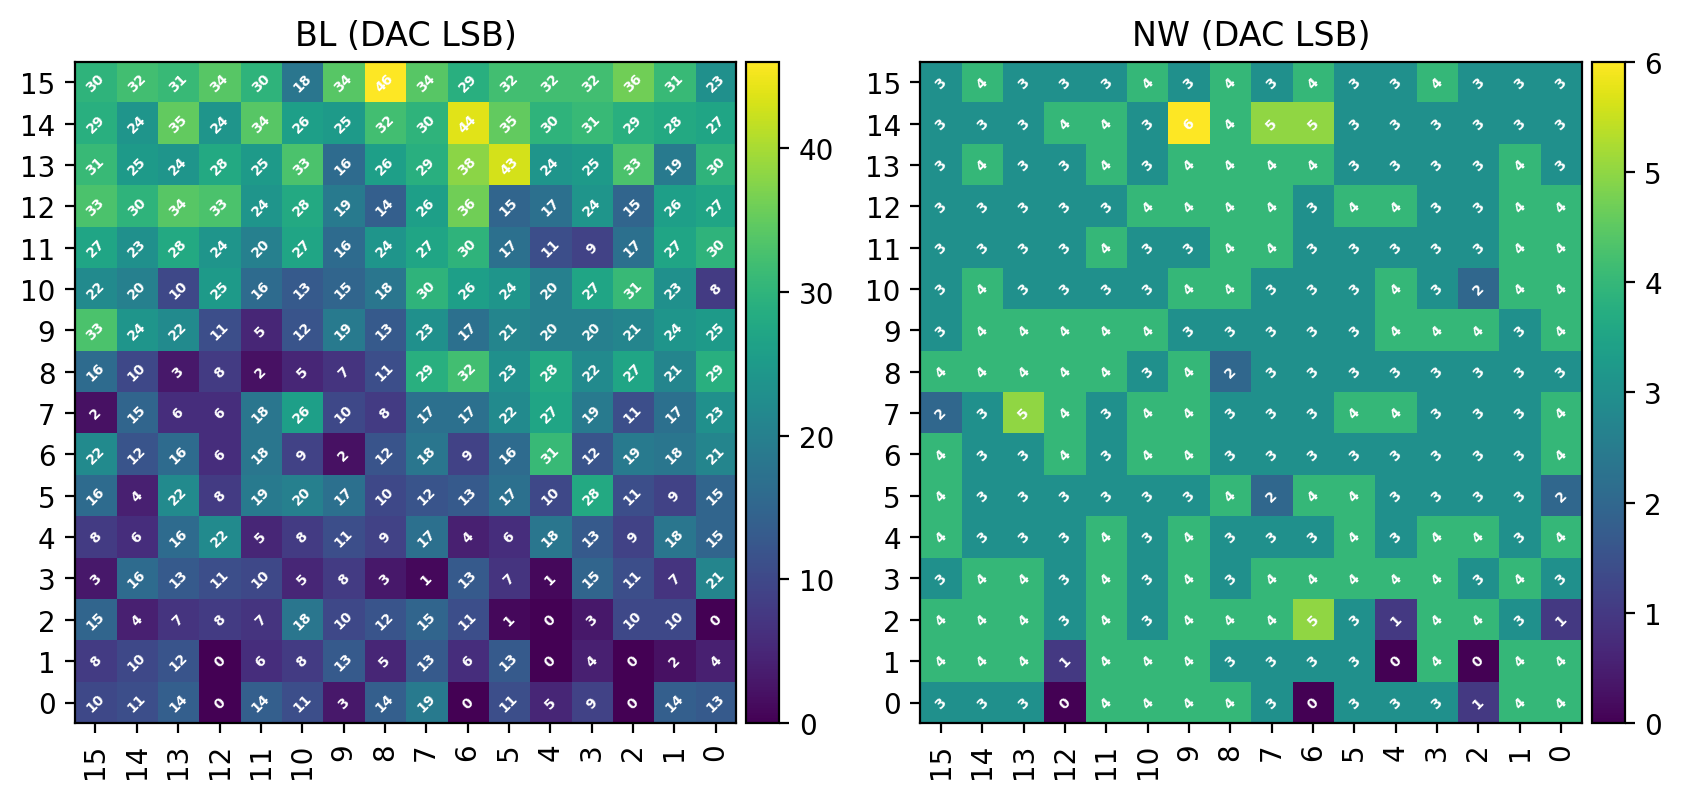

In [19]:
fig = plt.figure(dpi=200, figsize=(10,10))
gs = fig.add_gridspec(1,2)

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title("BL (DAC LSB)")
img0 = ax0.imshow(BL_map_THCal, interpolation='none')
ax0.set_aspect("equal")
ax0.invert_xaxis()
ax0.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax0)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img0, cax=cax, orientation="vertical")

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("NW (DAC LSB)")
img1 = ax1.imshow(NW_map_THCal, interpolation='none')
ax1.set_aspect("equal")
ax1.invert_xaxis()
ax1.invert_yaxis()
plt.xticks(range(16), range(16), rotation="vertical")
plt.yticks(range(16), range(16))
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(img1, cax=cax, orientation="vertical")

for x in range(16):
    for y in range(16):
        # if(BL_map_THCal.T[x,y]==0): continue
        ax0.text(x,y,f"{BL_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")
        ax1.text(x,y,f"{NW_map_THCal.T[x,y]:.0f}", c="white", size=5, rotation=45, fontweight="bold", ha="center", va="center")

#plt.show()

### Store BL, NW dataframe for later use

In [20]:
outdir = Path('../ETROC-Data')
outdir = outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
outdir.mkdir(exist_ok=True)
outfile = outdir / (chip_name+"_BaselineAt_" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M") + ".csv")
BL_df.to_csv(outfile, index=False)

# Test Full Chip Pipeline with pixel charge injection

### Disable all pixel readouts before doing anything

In [11]:
row_indexer_handle,_,_ = chip.get_indexer("row")
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(0)
row_indexer_handle.set(0)

broadcast_handle,_,_ = chip.get_indexer("broadcast")
broadcast_handle.set(True)
pixel_decoded_register_write("disDataReadout", "1")
broadcast_handle.set(True)
pixel_decoded_register_write("QInjEn", "0")


### Single Pixel Testing

#### Enable single pixel

In [12]:
# If you want, you can change the pixel row and column numbers
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
row = 3
col = 3
print(f"Enabling Pixel ({row},{col})")
column_indexer_handle.set(col)
row_indexer_handle.set(row)
pixel_decoded_register_write("TH_offset", format(0x0c, '06b'))  # Offset used to add to the auto BL for real triggering
pixel_decoded_register_write("QSel", format(0x0e, '05b'))       # Ensure we inject 15 fC of charge
pixel_decoded_register_write("disDataReadout", "0")             # ENable readout
pixel_decoded_register_write("QInjEn", "1")                     # ENable charge injection for the selected pixel

Enabling Pixel (3,3)


#### Data Acquisition

Make sure the IP address is correct for the FPGA being used. Note that the output is being sent to a folder called "test". User can tune max time of operation of this code (in seconds) using the -t flag

In [13]:
parser = run_script.getOptionParser()
(options, args) = parser.parse_args(args="--firmware --useIPC --hostname 192.168.2.3 -t 100 -o test -v -w --polarity 0x000b".split())
IPC_queue = multiprocessing.Queue()
process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, "main_process"))
process.start()

The following cell starts the trains of L1A and Qinj fast commands, each with a different frequency. L1A auccessfully catches the Qinj at the frequency of the beat pattern, with a period equal to the LCM of the two periods

In [14]:
IPC_queue.put('start L1A 1MHz')

The following cell calls software_clear_fifo(), which can be used to force the FPGA to reset the data link and look for the data frame boundaries once again. 

In [25]:
IPC_queue.put('link reset')

This cell stops data being written into files, and halts fifo read operations

In [15]:
IPC_queue.put('stop DAQ')

The following cell stopd the trains of L1A and Qinj fast commands

In [16]:
IPC_queue.put('stop L1A 1MHz')

This cell allows the read process to timeout, and allows the process to exit before the "-t" time in case the readout processes have been waiting for more than 30sec

In [17]:
IPC_queue.put('allow threads to exit')
process.join()

After ending the process, one can inspect the stored raw binary and translated files to check for data integrity

#### Disable single pixel

In [18]:
print(f"Disabling Pixel ({row},{col})")
row_indexer_handle,_,_ = chip.get_indexer("row")  # Returns 3 parameters: handle, min, max
column_indexer_handle,_,_ = chip.get_indexer("column")
column_indexer_handle.set(col)
row_indexer_handle.set(row)
pixel_decoded_register_write("QInjEn", "0")
pixel_decoded_register_write("disDataReadout", "1")

Disabling Pixel (3,3)


# Disconnect I2C Device

In [84]:
conn.disconnect()